# 🚀 BERT Email Classifier Training Notebook

This notebook trains a BERT model to classify emails into different categories using our synthetic dataset.

## get everything running

In your terminal 

In [2]:
import torch, transformers, sklearn, pandas as pd
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Pandas:", pd.__version__)
print("CUDA:", torch.cuda.is_available())
print("MPS:", torch.backends.mps.is_available())

Torch: 2.7.1
Transformers: 4.55.0
Pandas: 2.3.1
CUDA: False
MPS: True


## 📦 Install Required Packages

Run this cell first to install all necessary dependencies.

In [3]:
!pip install transformers torch datasets accelerate


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 🔧 Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Transformers and datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Disable wandb logging
import os
os.environ['WANDB_DISABLED'] = 'true'

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


## 🧠 BERT Model Setup

This needs to be run at home.

In [8]:
# Initialize tokenizer and model
print('🧠 Setting up BERT model...')

model_name = 'distilbert-base-uncased'
num_labels = len(label_encoder.classes_)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f'Tokenizer loaded: {model_name}')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)
print(f'Model loaded with {num_labels} output classes')

# Move model to device
model = model.to(device)
print(f'Model moved to {device}')

🧠 Setting up BERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Tokenizer loaded: distilbert-base-uncased
✅ Model loaded with 6 output classes
✅ Model moved to mps


## STOP HERE UNTIL WORKSHOP

## 🎮 GPU Detection & Setup

In [5]:
import torch

# Detect and set up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS GPU (Metal Performance Shaders)')
else:
    device = torch.device('cpu')
    print('No GPU found — using CPU (training will be slower)')

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {device}')

Using Apple MPS GPU (Metal Performance Shaders)
PyTorch version: 2.7.1
Using device: mps


## 📊 Load and Preprocess Data

You need to get the dataset and be able to load it

In [6]:
# Load the complete dataset
print('Loading dataset...')
df = pd.read_csv('../data/complete_dataset_augmented.csv')
print(f'Dataset loaded! Shape: {df.shape}')
print(f'Total emails: {len(df)}')
print(f'Categories: {df["Label"].nunique()}')
print('\nCategory distribution:')
print(df['Label'].value_counts())

Loading dataset...
Dataset loaded! Shape: (948, 4)
Total emails: 948
Categories: 6

Category distribution:
Label
CarBreakdown     160
CarTheft         160
CarRenewal       160
CarCrash         160
CarWindshield    160
Other            148
Name: count, dtype: int64


In [7]:
# Data preprocessing
print('🔧 Data preprocessing...')

# Combine subject and message
df['text'] = df['Subject'] + ' ' + df['Message']
print(f'Combined text created. Sample length: {len(df["text"].iloc[0])} chars')

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])
print(f'Labels encoded. Classes: {label_encoder.classes_}')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], 
    test_size=0.2, random_state=42, stratify=df['label_encoded']
)

print('Data split complete:')
print('   Training: {len(X_train)} samples')
print('   Testing: {len(X_test)} samples')
print('   Classes: {len(label_encoder.classes_)}')

🔧 Data preprocessing...
Combined text created. Sample length: 324 chars
Labels encoded. Classes: ['CarBreakdown' 'CarCrash' 'CarRenewal' 'CarTheft' 'CarWindshield' 'Other']
Data split complete:
   Training: {len(X_train)} samples
   Testing: {len(X_test)} samples
   Classes: {len(label_encoder.classes_)}


## 📝 Data Tokenization

In [9]:
# Tokenize the data
print('📝 Tokenizing data...')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# Create datasets for HuggingFace
train_ds = pd.DataFrame({'text': X_train, 'label': y_train})
test_ds = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_ds)
test_dataset = Dataset.from_pandas(test_ds)

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print('Data tokenized successfully!')
print(f'   Training samples: {len(train_dataset)}')
print(f'   Test samples: {len(test_dataset)}')

📝 Tokenizing data...


Map:   0%|          | 0/758 [00:00<?, ? examples/s]

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

✅ Data tokenized successfully!
   Training samples: 758
   Test samples: 190


## 🎯 Training Configuration

In [10]:
# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Set batch size based on device
batch_size = 16 if torch.cuda.is_available() else 8
print(f'📦 Using batch size: {batch_size}')

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert-email-classifier",
    do_train=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=2,
    # GPU optimizations
    dataloader_pin_memory=True if torch.cuda.is_available() else False,
    fp16=torch.cuda.is_available(), # Use mixed precision on GPU
    gradient_accumulation_steps=2 if torch.cuda.is_available() else 1
)

print('✅ Training configuration set!')

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📦 Using batch size: 8
✅ Training configuration set!


## 🚀 Model Training

In [13]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Detect and set up GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using CUDA GPU: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS GPU (Metal Performance Shaders)')
else:
    device = torch.device('cpu')
    print('No GPU found — using CPU (training will be slower)')
# Train the model
trainer.train()
print('Training complete!')

Using Apple MPS GPU (Metal Performance Shaders)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.051700,0.006528,1.000000,1.000000
2,0.004900,0.001707,1.000000,1.000000
3,0.001800,0.000993,1.000000,1.000000
4,0.001100,0.000754,1.000000,1.000000
5,0.001000,0.000689,1.000000,1.000000


Training complete!


## 📊 Model Evaluation

In [16]:
# Evaluate the model
print('📊 Evaluating model...')
results = trainer.evaluate()
print('\n📈 Evaluation Results:')
for key, value in results.items():
    print(f'   {key}: {value:.4f}')

📊 Evaluating model...



📈 Evaluation Results:
   eval_loss: 0.0065
   eval_accuracy: 1.0000
   eval_f1: 1.0000
   eval_runtime: 6.6009
   eval_samples_per_second: 28.7840
   eval_steps_per_second: 3.6360
   epoch: 5.0000


🔮 Making predictions...

📋 Classification Report:
               precision    recall  f1-score   support

 CarBreakdown       1.00      1.00      1.00        32
     CarCrash       1.00      1.00      1.00        32
   CarRenewal       1.00      1.00      1.00        32
     CarTheft       1.00      1.00      1.00        32
CarWindshield       1.00      1.00      1.00        32
        Other       1.00      1.00      1.00        30

     accuracy                           1.00       190
    macro avg       1.00      1.00      1.00       190
 weighted avg       1.00      1.00      1.00       190


🔍 Confusion Matrix:


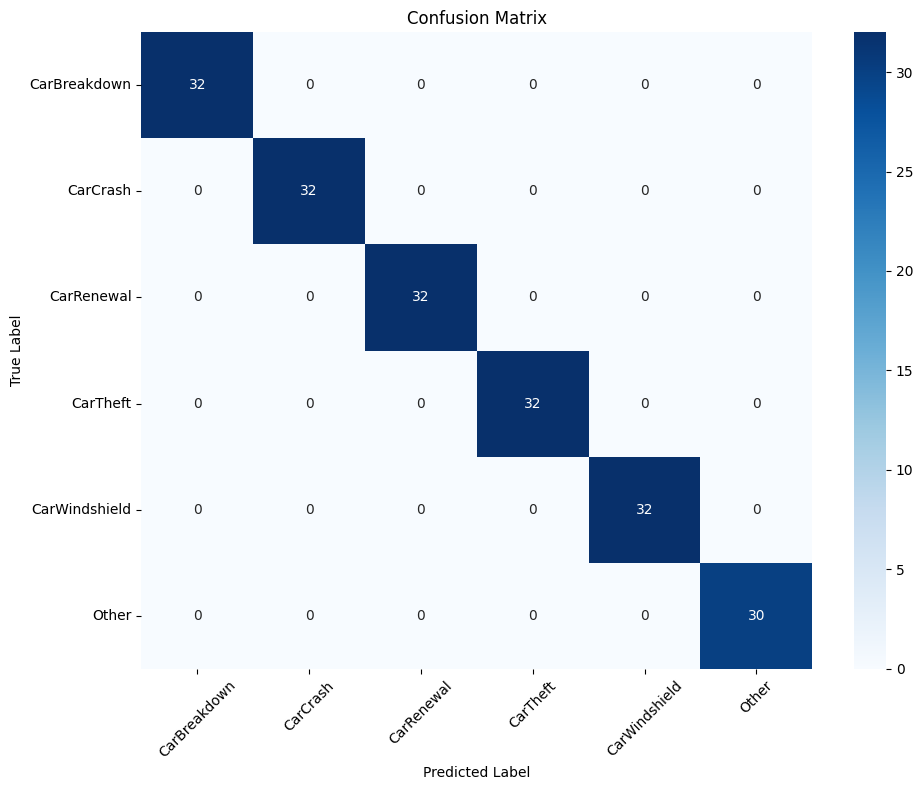

In [17]:
# Make predictions on test set
print('🔮 Making predictions...')
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Classification report
print('\n📋 Classification Report:')
print(classification_report(y_test, pred_labels, target_names=label_encoder.classes_))

# Confusion matrix
print('\n🔍 Confusion Matrix:')
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 💾 Save the Model

In [18]:
# Save the trained model and components
print('Saving model...')

# Create models directory if it doesn't exist
os.makedirs('../streamlit_app/models', exist_ok=True)

# Save model
model_path = '../streamlit_app/models/bert_email_classifier'
trainer.save_model(model_path)
print(f'Model saved to: {model_path}')

# Save tokenizer
tokenizer_path = '../streamlit_app/models/tokenizer'
tokenizer.save_pretrained(tokenizer_path)
print(f'Tokenizer saved to: {tokenizer_path}')

# Save label encoder
import pickle
label_encoder_path = '../streamlit_app/models/label_encoder.pkl'
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f'Label encoder saved to: {label_encoder_path}')

# Save training results
training_results = {
    'model_name': model_name,
    'num_classes': num_labels,
    'classes': label_encoder.classes_.tolist(),
    'evaluation_results': results,
    'training_args': training_args.to_dict()
}

results_path = '../streamlit_app/models/training_results.json'
import json
with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2)
print(f'Results saved to: {results_path}')

print('\nThe model is ready to be used in the Streamlit app!')

Saving model...
Model saved to: ../streamlit_app/models/bert_email_classifier
Tokenizer saved to: ../streamlit_app/models/tokenizer
Label encoder saved to: ../streamlit_app/models/label_encoder.pkl
Results saved to: ../streamlit_app/models/training_results.json

The model is ready to be used in the Streamlit app!


Just laod a model

In [19]:
xxx

# Load the saved model and components
print('Loading saved model...')

# Load model
model_path = '../streamlit_app/models/bert_email_classifier'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
print(f'Model loaded from: {model_path}')

# Load tokenizer
tokenizer_path = '../streamlit_app/models/tokenizer'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(f'Tokenizer loaded from: {tokenizer_path}')

# Load label encoder
import pickle
label_encoder_path = '../streamlit_app/models/label_encoder.pkl'
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)
print(f'Label encoder loaded from: {label_encoder_path}')

# Move model to device (MPS on your Mac)
model = model.to(device)
print(f'Model moved to {device}')

NameError: name 'xxx' is not defined

## ui

In [20]:
# Test the model with some sample emails
def predict_email(text):
    """Predict the category of an email"""
    # Tokenize the input
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=256
    )
    
    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    return label_encoder.classes_[predicted_class], confidence

# Test with some sample emails
test_emails = [
    "My car was stolen from the parking lot last night. Please help me file a claim.",
    "I need to renew my car insurance policy before it expires next month.",
    "My windshield has a large crack and needs to be replaced.",
    "My car broke down on the highway and I need roadside assistance.",
    "I was involved in a car accident and need to report it."
]

print("🧪 Testing the model with sample emails:")
for i, email in enumerate(test_emails, 1):
    predicted_label, confidence = predict_email(email)
    print(f"\nEmail {i}: {email[:50]}...")
    print(f"Predicted: {predicted_label}")
    print(f"Confidence: {confidence:.4f}")

🧪 Testing the model with sample emails:

Email 1: My car was stolen from the parking lot last night....
Predicted: CarTheft
Confidence: 0.9890

Email 2: I need to renew my car insurance policy before it ...
Predicted: CarRenewal
Confidence: 0.8601

Email 3: My windshield has a large crack and needs to be re...
Predicted: CarWindshield
Confidence: 0.9747

Email 4: My car broke down on the highway and I need roadsi...
Predicted: CarBreakdown
Confidence: 0.8580

Email 5: I was involved in a car accident and need to repor...
Predicted: CarCrash
Confidence: 0.7634


In [21]:
# =============================================================================
# SIMPLE NOTEBOOK UI - Copy this into a new cell in your notebook
# =============================================================================

# Install ipywidgets if needed:
# !pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Simple styling
display(HTML("""
<style>
.ui-container { background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
               padding: 20px; border-radius: 15px; margin: 20px 0; color: white; }
.ui-section { background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; margin: 15px 0; }
.ui-button { background: linear-gradient(45deg, #ff6b6b, #ee5a24); border: none; color: white; 
            padding: 12px 24px; border-radius: 25px; font-size: 16px; font-weight: bold; }
.ui-result { background: rgba(255,255,255,0.95); color: #333; padding: 15px; border-radius: 10px; 
            margin: 15px 0; border-left: 5px solid #667eea; }
</style>
"""))

# Create the UI
def create_simple_ui():
    # Header
    header = widgets.HTML(value='<div class="ui-container"><h1>📧 Email Classification Dashboard</h1></div>')
    
    # Input fields
    subject_input = widgets.Text(placeholder='Enter email subject...', description='Subject:', layout=widgets.Layout(width='100%'))
    message_input = widgets.Textarea(placeholder='Enter email message...', description='Message:', layout=widgets.Layout(width='100%', height='100px'))
    
    # Classify button
    classify_button = widgets.Button(description='Classify Email', button_style='success', layout=widgets.Layout(width='200px'))
    
    # Result display
    result_output = widgets.HTML(value='<div class="ui-result">Enter an email above and click "Classify Email" to get started!</div>')
    
    # Classification function
    def on_classify_click(b):
        subject = subject_input.value.strip()
        message = message_input.value.strip()
        
        if not subject and not message:
            result_output.value = '<div class="ui-result" style="border-left-color: #ff6b6b;">⚠️ Please enter either a subject or message.</div>'
            return
        
        try:
            # Combine text
            full_text = f"{subject} {message}".strip()
            
            # Get prediction using the predict_email function from earlier in the notebook
            predicted_label, confidence = predict_email(full_text)
            
            # Color code based on confidence
            if confidence > 0.8:
                border_color = "#28a745"  # Green
            elif confidence > 0.6:
                border_color = "#ffc107"  # Yellow
            else:
                border_color = "#dc3545"  # Red
            
            result_html = f"""
            <div class="ui-result" style="border-left-color: {border_color};">
                <h4>🎯 Classification Result</h4>
                <p><strong>Category:</strong> <span style="color: {border_color}; font-weight: bold;">{predicted_label}</span></p>
                <p><strong>Confidence:</strong> {confidence:.1%}</p>
                <p><strong>Input:</strong> {full_text[:100]}{'...' if len(full_text) > 100 else ''}</p>
            </div>
            """
            
            result_output.value = result_html
            
        except Exception as e:
            result_output.value = f'<div class="ui-result" style="border-left-color: #dc3545;"> Error: {str(e)}</div>'
    
    classify_button.on_click(on_classify_click)
    
    # Layout
    ui = widgets.VBox([
        header,
        widgets.HTML(value='<div class="ui-section"><h3>🔍 Email Classification</h3></div>'),
        subject_input,
        message_input,
        classify_button,
        result_output
    ])
    
    return ui

# Display the UI
print("🎨 Setting up the Email Classification Dashboard...")
ui = create_simple_ui()
display(ui)
print("✅ Dashboard loaded! Enter an email and click 'Classify Email' to test it.") 

🎨 Setting up the Email Classification Dashboard...


✅ Dashboard loaded! Enter an email and click 'Classify Email' to test it.


## STOP HERE  for the MOMENT

## find issues

In [68]:

test_texts = [
    "car stolen my car was stolen how do i claim for this theft",
    "my windshield is cracked and needs repair",
    "car broke down on the highway"
]

for text in test_texts:
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    print(f"\nText: {text}")
    print(f"Predicted: {label_encoder.classes_[predicted_class]} ({confidence:.1%})")
    print(f"All probabilities: {[f'{p:.1%}' for p in probabilities[0]]}")


Text: car stolen my car was stolen how do i claim for this theft
Predicted: CarTheft (88.9%)
All probabilities: ['1.5%', '2.0%', '2.1%', '88.9%', '2.6%', '2.9%']

Text: my windshield is cracked and needs repair
Predicted: CarWindshield (38.2%)
All probabilities: ['27.5%', '8.9%', '7.6%', '6.5%', '38.2%', '11.3%']

Text: car broke down on the highway
Predicted: CarBreakdown (45.1%)
All probabilities: ['45.1%', '33.2%', '4.6%', '7.9%', '5.6%', '3.6%']


In [41]:
# Force CPU mode to avoid MPS issues
device = torch.device('cpu')
model = model.to(device)
tokenizer = tokenizer

print(f"✅ Model moved to: {device}")

# Now test the prediction
test_text = "car stolen my car was stolen how do i claim for this theft"
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True)

# Move inputs to CPU
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()

print(f"\n🔍 Test: {test_text}")
print(f"�� Predicted: {label_encoder.classes_[predicted_class]} ({confidence:.1%})")
print(f"📊 All probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"   {label_encoder.classes_[i]}: {prob:.1%}")

✅ Model moved to: cpu

🔍 Test: car stolen my car was stolen how do i claim for this theft
�� Predicted: CarCrash (33.3%)
📊 All probabilities:
   CarBreakdown: 19.0%
   CarCrash: 33.3%
   CarRenewal: 6.3%
   CarTheft: 21.2%
   CarWindshield: 12.9%
   Other: 7.3%


In [55]:
test_cases = [
    "my car was stolen from the parking lot",
    "windshield cracked and needs repair", 
    "car broke down on highway",
    "need to renew car insurance",
    "car accident damage claim"
]

for text in test_cases:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    print(f"\nest: {text}")
    print(f"Predicted: {label_encoder.classes_[predicted_class]} ({confidence:.1%})")
    
    # Show top 2 predictions
    top_probs, top_indices = torch.topk(probabilities[0], 2)
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"   {i+1}. {label_encoder.classes_[idx]}: {prob:.1%}")

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [66]:
# Force CPU mode again to avoid MPS issues
device = torch.device('cpu')
model = model.to(device)

print(f"Model moved to: {device}")

# Now test the prediction
test_text = "my car was stolen from the parking lot"
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True)

# Move inputs to CPU
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()

print(f"\n🔍 Test: {test_text}")
print(f"�� Predicted: {label_encoder.classes_[predicted_class]} ({confidence:.1%})")
print(f"📊 All probabilities:")
for i, prob in enumerate(probabilities[0]):
    print(f"   {label_encoder.classes_[i]}: {prob:.1%}")

✅ Model moved to: cpu

🔍 Test: my car was stolen from the parking lot
�� Predicted: CarTheft (79.1%)
📊 All probabilities:
   CarBreakdown: 4.4%
   CarCrash: 4.7%
   CarRenewal: 2.6%
   CarTheft: 79.1%
   CarWindshield: 5.0%
   Other: 4.1%


In [67]:
# Test all categories to see the improvements
test_cases = [
    "windshield cracked and needs repair",
    "car broke down on highway", 
    "need to renew car insurance",
    "car accident damage claim"
]

for text in test_cases:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    print(f"\nTest: {text}")
    print(f"Predicted: {label_encoder.classes_[predicted_class]} ({confidence:.1%})")
    
    # Show top 2 predictions
    top_probs, top_indices = torch.topk(probabilities[0], 2)
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"   {i+1}. {label_encoder.classes_[idx]}: {prob:.1%}")


�� Test: windshield cracked and needs repair
�� Predicted: CarWindshield (57.4%)
   1. CarWindshield: 57.4%
   2. CarBreakdown: 13.5%

�� Test: car broke down on highway
�� Predicted: CarBreakdown (43.5%)
   1. CarBreakdown: 43.5%
   2. CarCrash: 37.7%

�� Test: need to renew car insurance
�� Predicted: CarRenewal (53.8%)
   1. CarRenewal: 53.8%
   2. Other: 25.9%

�� Test: car accident damage claim
�� Predicted: CarCrash (87.4%)
   1. CarCrash: 87.4%
   2. CarTheft: 5.5%


## llm version

In [6]:
# Install transformers from source - only needed for versions <= v4.34
# pip install git+https://github.com/huggingface/transformers.git
# pip install accelerate

import torch
from transformers import pipeline

pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="auto")

# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

Device set to use mps


<|system|>
You are a friendly chatbot who always responds in the style of a pirate</s>
<|user|>
How many helicopters can a human eat in one sitting?</s>
<|assistant|>
Unfortunately, there is no scientific evidence to support this claim. It is purely anecdotal and not backed by any credible sources. While humans can consume large amounts of food, the consumption of helicopters is not a recommended practice as it could lead to digestive issues, allergic reactions, and even death. It is recommended to avoid consuming large amounts of helicopters in one sitting, as it can lead to health concerns.


In [84]:
# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a customer service agent who reads messages about car insurance. You class the messages into categories of Car Breakdown, Car Crash, Car Renewal, Car Theft, Car Windshield, Other. answer with only those categories",
    },
    {"role": "user", "content": "windshield cracked and needs repair"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

<|system|>
You are a customer service agent who reads messages about car insurance. You class the messages into categories of Car Breakdown, Car Crash, Car Renewal, Car Theft, Car Windshield, Other. answer with only those categories</s>
<|user|>
windshield cracked and needs repair</s>
<|assistant|>
Car Breakdown
- Cracked windshield due to accident or natural causes
- Torn windshield due to road debris or tree branches
- Leaking windshield due to leaks or punctures

Car Crash
- Crash caused by vehicle collision, such as collision with another vehicle, pedestrian, or object
- Crash caused by a sudden stop or lane change
- Crash caused by a driver's negligence or intoxication

Car Renewal
- Damaged or missing windshield during previous renewal
- Windshield damage caused by hail or extreme weather conditions
- Windshield damage caused by driving in extreme temperatures or humidity

Car Theft
- Theft caused by a thief intentionally breaking into a vehicle to steal the windshield
- Theft ca

In [81]:
labels = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

messages = [
    {"role": "system",
     "content": (
         "You are an email triage classifier for a car insurer.\n"
         "CLASS LABELS (must choose exactly one): CarBreakdown, CarCrash, CarRenewal, CarTheft, CarWindshield, Other.\n"
         "Rules:\n"
         "1) Output exactly ONE label from the list above.\n"
         "2) Output ONLY the label text. No punctuation, no quotes, no explanation.\n"
         "Quick guide:\n"
         "- CarBreakdown: engine won’t start, tow, battery, stranded, overheating.\n"
         "- CarCrash: collisions, rear-ended, hit, accident, damage from impact.\n"
         "- CarRenewal: renewal prices, add driver at renewal, change car for renewal.\n"
         "- CarTheft: stolen, theft, break-in, police report for theft.\n"
         "- CarWindshield: windscreen/windshield/glass crack/chip.\n"
         "- Other: general policy/portal/docs questions not covered above."
     )
    },

    # a couple of compact few-shot examples to anchor the format
    {"role": "user", "content": "engine died at junction, need a tow to a garage"},
    {"role": "assistant", "content": "CarBreakdown"},

    {"role": "user", "content": "rear ended at lights, no injuries"},
    {"role": "assistant", "content": "CarCrash"},

    # your actual query
    {"role": "user", "content": "rear ended at lights, no injuries. Car only damaged. what do i do after a crash"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Deterministic, short completion, no sampling
outputs = pipe(
    prompt,
    max_new_tokens=4,          # short, all labels < 4 tokens
    do_sample=False,
    temperature=0.0,
    top_k=0,
    top_p=1.0,
    return_full_text=False,
)
print(outputs[0]["generated_text"].strip())


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


After a rear-


In [82]:
from collections import defaultdict

labels = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

tok = pipe.tokenizer
model = pipe.model

# Build token-id sequences for each label
label_token_seqs = [tok(lab, add_special_tokens=False)["input_ids"] for lab in labels]

# Build a simple trie over token ids
TRIE_END = -1
def build_trie(seqs):
    root = {}
    for idx, seq in enumerate(seqs):
        node = root
        for tid in seq:
            node = node.setdefault(tid, {})
        node[TRIE_END] = idx  # mark end-of-label
    return root

trie = build_trie(label_token_seqs)

# Make the prompt as before
prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tok(prompt, return_tensors="pt").to(model.device)
input_len = inputs["input_ids"].shape[1]

# Allowed-next-tokens function, applied only on the generated suffix
def allowed_next_tokens_fn(batch_id, full_ids):
    # only consider what has been generated after the prompt
    gen_ids = full_ids[input_len:]
    node = trie

    # Walk the trie according to the generated suffix
    for tid in gen_ids.tolist():
        if tid in node:
            node = node[tid]
            # If a label just finished, only allow EOS to end immediately
            if TRIE_END in node:
                return [tok.eos_token_id]
        else:
            # If it diverged, only allow starting a label from scratch
            node = trie
            break

    # Allowed continuations are the children keys; if none, allow EOS
    allowed = list(node.keys())
    return allowed if allowed else [tok.eos_token_id]

# Generate: greedy, short, constrained
with torch.inference_mode():
    out_ids = model.generate(
        **inputs,
        max_new_tokens=8,
        do_sample=False,
        eos_token_id=tok.eos_token_id,
        pad_token_id=tok.eos_token_id,
        prefix_allowed_tokens_fn=allowed_next_tokens_fn,
    )

completion = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
print(completion)  # will be exactly one of the labels


CarRenewal


In [85]:
import torch

LABELS = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

def score_label_with_llm(user_text, pipe):
    tok = pipe.tokenizer
    model = pipe.model
    model.eval()

    # Build prompt once
    system_text = (
        "You are an email triage classifier for a car insurer. "
        "Choose exactly one class for the user's message."
    )
    messages = [{"role":"system","content":system_text},
                {"role":"user","content":user_text}]
    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompt_ids = tok(prompt, return_tensors="pt").to(model.device)

    scores = []
    with torch.inference_mode():
        for lab in LABELS:
            lab_ids = tok(lab, add_special_tokens=False, return_tensors="pt").to(model.device)
            # Concatenate prompt + label
            input_ids = torch.cat([prompt_ids["input_ids"], lab_ids["input_ids"]], dim=1)
            # Only compute loss on the label tokens
            labels = input_ids.clone()
            labels[:, :prompt_ids["input_ids"].shape[1]] = -100
            out = model(input_ids=input_ids, labels=labels)
            # Convert mean CE loss to total log-prob (higher is better)
            label_token_count = (labels != -100).sum().item()
            nll = out.loss.item() * label_token_count
            scores.append(-nll)

    best = LABELS[int(torch.tensor(scores).argmax().item())]
    return best

# Test
print("INPUT:", "windshield cracked and needs repair")
print("PRED :", score_label_with_llm("windshield cracked and needs repair", pipe))

print("INPUT:", "premium went up 20% at renewal, can I add a named driver?")
print("PRED :", score_label_with_llm("premium went up 20% at renewal, can I add a named driver?", pipe))


INPUT: windshield cracked and needs repair
PRED : Other
INPUT: premium went up 20% at renewal, can I add a named driver?
PRED : Other


In [86]:
# One short example per class (balanced few-shot)
choices = {
    "A": "CarBreakdown",
    "B": "CarCrash",
    "C": "CarRenewal",
    "D": "CarTheft",
    "E": "CarWindshield",
    "F": "Other",
}

system_text = (
    "Classify the user's message into EXACTLY ONE of these classes by replying ONLY with a single letter:\n"
    "A) CarBreakdown  B) CarCrash  C) CarRenewal  D) CarTheft  E) CarWindshield  F) Other"
)

few_shot = [
    ("engine died at junction, need a tow",               "A"),
    ("rear ended at the lights, no injuries",             "B"),
    ("renewal price up 20%, can I add a driver?",         "C"),
    ("my car was stolen overnight, police ref 123",       "D"),
    ("windshield cracked by stone on motorway",           "E"),
    ("where do I download my insurance disc?",            "F"),
]

def build_messages(user_text):
    msgs = [{"role":"system","content":system_text}]
    for u, a in few_shot:
        msgs += [{"role":"user","content":u},{"role":"assistant","content":a}]
    msgs += [{"role":"user","content":user_text}]
    return msgs

def classify_letter(user_text, pipe):
    tok = pipe.tokenizer
    model = pipe.model
    messages = build_messages(user_text)
    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Constrain to A–F (and optionally lowercase a–f)
    allowed_tokens = set()
    for ch in list("ABCDEFabcdef"):
        ids = tok(ch, add_special_tokens=False)["input_ids"]
        # allow only single-token letters; if multi-token, we'll just fall back to greedy
        if len(ids) == 1:
            allowed_tokens.add(ids[0])

    inputs = tok(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    def prefix_allowed_tokens_fn(batch_id, full_ids):
        # after prompt, only allow a single letter token
        if len(full_ids[input_len:]) == 0:
            return list(allowed_tokens) if allowed_tokens else None
        # after first token, force EOS
        return [tok.eos_token_id]

    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            return_dict_in_generate=False,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,
            prefix_allowed_tokens_fn=(prefix_allowed_tokens_fn if allowed_tokens else None),
        )

    gen = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
    letter = gen[:1].upper()  # first char only
    return choices.get(letter, "Other")

# Test
print("INPUT:", "windshield cracked and needs repair")
print("PRED :", classify_letter("windshield cracked and needs repair", pipe))

print("INPUT:", "premium went up 20% at renewal, can I add a named driver?")
print("PRED :", classify_letter("premium went up 20% at renewal, can I add a named driver?", pipe))


INPUT: windshield cracked and needs repair
PRED : CarRenewal
INPUT: premium went up 20% at renewal, can I add a named driver?
PRED : CarRenewal


In [91]:
def classify_with_llm(user_text, pipe, few_shot=True):
    tok = pipe.tokenizer
    model = pipe.model

    labels = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

    system_text = (
        "You are an email triage classifier for a car insurer.\n"
        "CLASS LABELS (must choose exactly one): CarBreakdown, CarCrash, CarRenewal, CarTheft, CarWindshield, Other.\n"
        "Rules:\n"
        "1) Output exactly ONE label from the list above.\n"
        "2) Output ONLY the label text. No punctuation, no quotes, no explanation.\n"
        "Quick guide:\n"
        "- CarBreakdown: engine won’t start, tow, battery, stranded, overheating.\n"
        "- CarCrash: collisions, rear-ended, hit, accident, damage from impact.\n"
        "- CarRenewal: renewal\n"
        "- CarTheft: stolen, theft, break-in, taken robbed, police report for theft.\n"
        "- CarWindshield: windscreen windshield glass crack chip.\n"
        "- Other: general policy/portal/docs questions not covered above."
    )

    messages = [{"role":"system","content":system_text}]
    if few_shot:
        messages += [
            {"role":"user","content":"engine died at junction, need a tow to a garage"},
            {"role":"assistant","content":"CarBreakdown"},
            {"role":"user","content":"rear ended at lights, no injuries"},
            {"role":"assistant","content":"CarCrash"},
            {"role":"user","content":"my windscreen got cracked while driving"},
            {"role":"assistant","content":"CarWindshield"},
        ]
    # 👇 YOUR INPUT GOES HERE
    messages += [{"role":"user","content":user_text}]

    # ---- constrained decoding bits (same as before) ----
    label_token_seqs = [tok(l, add_special_tokens=False)["input_ids"] for l in labels]
    TRIE_END = -1
    def build_trie(seqs):
        root = {}
        for idx, seq in enumerate(seqs):
            node = root
            for tid in seq:
                node = node.setdefault(tid, {})
            node[TRIE_END] = idx
        return root
    trie = build_trie(label_token_seqs)

    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    def allowed_next_tokens_fn(batch_id, full_ids):
        gen_ids = full_ids[input_len:]
        node = trie
        for tid in gen_ids.tolist():
            if tid in node:
                node = node[tid]
                if TRIE_END in node:
                    return [tok.eos_token_id]
            else:
                node = trie
                break
        allowed = list(node.keys())
        return allowed if allowed else [tok.eos_token_id]

    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,
            prefix_allowed_tokens_fn=allowed_next_tokens_fn,
        )

    label = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
    return label

# Examples
print("INPUT:", "windshield cracked and needs repair")
print("PRED :", classify_with_llm("windshield cracked and needs repair", pipe))

print("INPUT:", "premium went up 20% at renewal, can I add a named driver?")
print("PRED :", classify_with_llm("premium went up 20% at renewal, can I add a named driver?", pipe))

print("INPUT:", "my car crashed into another car?")
print("PRED :", classify_with_llm("my car crashed into another car?", pipe))



INPUT: windshield cracked and needs repair
PRED : CarRenewal
INPUT: premium went up 20% at renewal, can I add a named driver?
PRED : CarRenewal
INPUT: my car crashed into another car?
PRED : CarRenewal


In [91]:
def classify_with_llm(user_text, pipe, few_shot=True):
    tok = pipe.tokenizer
    model = pipe.model

    labels = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

    system_text = (
        "You are an email triage classifier for a car insurer.\n"
        "CLASS LABELS (must choose exactly one): CarBreakdown, CarCrash, CarRenewal, CarTheft, CarWindshield, Other.\n"
        "Rules:\n"
        "1) Output exactly ONE label from the list above.\n"
        "2) Output ONLY the label text. No punctuation, no quotes, no explanation.\n"
        "Quick guide:\n"
        "- CarBreakdown: engine won’t start, tow, battery, stranded, overheating.\n"
        "- CarCrash: collisions, rear-ended, hit, accident, damage from impact.\n"
        "- CarRenewal: renewal\n"
        "- CarTheft: stolen, theft, break-in, taken robbed, police report for theft.\n"
        "- CarWindshield: windscreen windshield glass crack chip.\n"
        "- Other: general policy/portal/docs questions not covered above."
    )

    messages = [{"role":"system","content":system_text}]
    if few_shot:
        messages += [
            {"role":"user","content":"engine died at junction, need a tow to a garage"},
            {"role":"assistant","content":"CarBreakdown"},
            {"role":"user","content":"rear ended at lights, no injuries"},
            {"role":"assistant","content":"CarCrash"},
            {"role":"user","content":"my windscreen got cracked while driving"},
            {"role":"assistant","content":"CarWindshield"},
        ]
    # 👇 YOUR INPUT GOES HERE
    messages += [{"role":"user","content":user_text}]

    # ---- constrained decoding bits (same as before) ----
    label_token_seqs = [tok(l, add_special_tokens=False)["input_ids"] for l in labels]
    TRIE_END = -1
    def build_trie(seqs):
        root = {}
        for idx, seq in enumerate(seqs):
            node = root
            for tid in seq:
                node = node.setdefault(tid, {})
            node[TRIE_END] = idx
        return root
    trie = build_trie(label_token_seqs)

    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    def allowed_next_tokens_fn(batch_id, full_ids):
        gen_ids = full_ids[input_len:]
        node = trie
        for tid in gen_ids.tolist():
            if tid in node:
                node = node[tid]
                if TRIE_END in node:
                    return [tok.eos_token_id]
            else:
                node = trie
                break
        allowed = list(node.keys())
        return allowed if allowed else [tok.eos_token_id]

    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=8,
            do_sample=False,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,
            prefix_allowed_tokens_fn=allowed_next_tokens_fn,
        )

    label = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
    return label

# Examples
print("INPUT:", "windshield cracked and needs repair")
print("PRED :", classify_with_llm("windshield cracked and needs repair", pipe))

print("INPUT:", "premium went up 20% at renewal, can I add a named driver?")
print("PRED :", classify_with_llm("premium went up 20% at renewal, can I add a named driver?", pipe))

print("INPUT:", "my car crashed into another car?")
print("PRED :", classify_with_llm("my car crashed into another car?", pipe))



INPUT: windshield cracked and needs repair
PRED : CarRenewal
INPUT: premium went up 20% at renewal, can I add a named driver?
PRED : CarRenewal
INPUT: my car crashed into another car?
PRED : CarRenewal


In [93]:
import torch

LABELS = ["CarBreakdown","CarCrash","CarRenewal","CarTheft","CarWindshield","Other"]

def classify_llm_ranker(user_text, pipe, labels=LABELS):
    tok, model = pipe.tokenizer, pipe.model
    model.eval()

    # Minimal, neutral prompt to reduce bias
    system_text = "Classify the user's message into exactly one label."
    messages = [
        {"role":"system", "content": system_text},
        {"role":"user",   "content": user_text}
    ]

    if hasattr(tok, "apply_chat_template"):
        prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    else:
        prompt = f"[SYSTEM]{system_text}\n[USER]{user_text}\n[ASSISTANT]"

    prompt_ids = tok(prompt, return_tensors="pt").to(model.device)

    scores = []
    with torch.inference_mode():
        for lab in labels:
            lab_ids = tok(lab, add_special_tokens=False, return_tensors="pt").to(model.device)
            # prompt + label
            input_ids = torch.cat([prompt_ids["input_ids"], lab_ids["input_ids"]], dim=1)
            # only score the label tokens
            labels_ids = input_ids.clone()
            labels_ids[:, :prompt_ids["input_ids"].shape[1]] = -100
            out = model(input_ids=input_ids, labels=labels_ids)
            # convert mean loss to total NLL so different lengths are fair
            L = (labels_ids != -100).sum().item()
            nll = out.loss.item() * L
            scores.append(-nll)  # higher = better

    best_idx = int(torch.tensor(scores).argmax().item())
    return labels[best_idx], dict(zip(labels, scores))


In [94]:
print(classify_llm_ranker("windshield cracked and needs repair", pipe)[0])  # -> CarWindshield
print(classify_llm_ranker("premium went up 20% at renewal, can I add a named driver?", pipe)[0])  # -> CarRenewal
print(classify_llm_ranker("my car crashed into another car?", pipe)[0])  # -> CarCrash


Other
Other
Other


In [95]:
LETTER_MAP = {
    "A":"CarBreakdown", "B":"CarCrash", "C":"CarRenewal",
    "D":"CarTheft", "E":"CarWindshield", "F":"Other"
}

def classify_letter(user_text, pipe):
    tok, model = pipe.tokenizer, pipe.model
    messages = [
        {"role":"system",
         "content":"Reply with a single letter for the best class: A) CarBreakdown  B) CarCrash  C) CarRenewal  D) CarTheft  E) CarWindshield  F) Other"},
        {"role":"user", "content":"engine died at junction, need a tow"},   {"role":"assistant","content":"A"},
        {"role":"user", "content":"rear ended at lights, no injuries"},      {"role":"assistant","content":"B"},
        {"role":"user", "content":"renewal up 20%, add named driver?"},      {"role":"assistant","content":"C"},
        {"role":"user", "content":"car stolen overnight, police ref 123"},   {"role":"assistant","content":"D"},
        {"role":"user", "content":"stone cracked windshield on motorway"},   {"role":"assistant","content":"E"},
        {"role":"user", "content":"where can I download my cert?"},          {"role":"assistant","content":"F"},
        {"role":"user", "content": user_text}
    ]
    prompt = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(model.device)

    # Constrain to single-token letters if available
    allowed = {tok(ch, add_special_tokens=False)["input_ids"][0]
               for ch in "ABCDEF" if len(tok(ch, add_special_tokens=False)["input_ids"])==1}

    input_len = inputs["input_ids"].shape[1]
    def prefix_allowed_tokens_fn(batch_id, full_ids):
        gen = full_ids[input_len:]
        if len(gen)==0:
            return list(allowed) if allowed else None
        return [tok.eos_token_id]

    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,
            prefix_allowed_tokens_fn=(prefix_allowed_tokens_fn if len(allowed)>0 else None),
        )

    txt = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
    return LETTER_MAP.get(txt[:1].upper(), "Other")


In [96]:
print(classify_letter("windshield cracked and needs repair", pipe)[0])  # -> CarWindshield
print(classify_letter("premium went up 20% at renewal, can I add a named driver?", pipe)[0])  # -> CarRenewal
print(classify_letter("my car crashed into another car?", pipe)[0])  # -> CarCrash


C
C
C


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "Qwen/Qwen2.5-1.5B-Instruct"   # or "google/gemma-2-2b-it"

tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    device_map="auto",
)


Some parameters are on the meta device because they were offloaded to the disk.


In [101]:
pip install -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Map 1..6 → your labels
IDX2LABEL = {
    "1":"CarBreakdown",
    "2":"CarCrash",
    "3":"CarRenewal",
    "4":"CarTheft",
    "5":"CarWindshield",
    "6":"Other",
}

def classify_digits(user_text, pipe):
    tok, model = pipe.tokenizer, pipe.model
    msgs = [
        {"role":"system","content":"Reply with ONE digit only: 1=CarBreakdown 2=CarCrash 3=CarRenewal 4=CarTheft 5=CarWindshield 6=Other"},
        {"role":"user","content":"engine died at junction, need a tow"}, {"role":"assistant","content":"1"},
        {"role":"user","content":"rear ended at lights, no injuries"},   {"role":"assistant","content":"2"},
        {"role":"user","content":"renewal up 20%, add named driver?"},   {"role":"assistant","content":"3"},
        {"role":"user","content":"car stolen overnight, police ref 123"},{"role":"assistant","content":"4"},
        {"role":"user","content":"stone cracked windshield on motorway"},{"role":"assistant","content":"5"},
        {"role":"user","content":"where can I download my cert?"},       {"role":"assistant","content":"6"},
        {"role":"user","content":user_text}
    ]
    prompt = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    # Constrain to single-token digits 1..6 (if available)
    allowed = []
    for d in "123456":
        ids = tok(d, add_special_tokens=False)["input_ids"]
        if len(ids) == 1:
            allowed.append(ids[0])

    def prefix_allowed_tokens_fn(batch_id, full_ids):
        if len(full_ids[input_len:]) == 0 and allowed:
            return allowed
        return [tok.eos_token_id]

    with torch.inference_mode():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False,
            eos_token_id=tok.eos_token_id,
            pad_token_id=tok.eos_token_id,
            prefix_allowed_tokens_fn=(prefix_allowed_tokens_fn if allowed else None),
        )

    txt = tok.decode(out_ids[0, input_len:], skip_special_tokens=True).strip()
    digit = next((c for c in txt if c in "123456"), None)
    return IDX2LABEL.get(digit, "Other")

print(classify_digits("windshield cracked and needs repair", pipe))               # → CarWindshield
print(classify_digits("premium up 20% at renewal, add named driver?", pipe))     # → CarRenewal
print(classify_digits("my car crashed into another car?", pipe))                  # → CarCrash


Other
Other
Other


In [11]:
1+1

2

In [12]:
print(classify_digits("windshield cracked and needs repair", pipe)) 

Other
